In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler

import cmdstanpy
from cmdstanpy import CmdStanModel

In [8]:
df = pd.read_csv("df_balanced.csv")

In [9]:
df.columns

Index(['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale',
       'Creatinina', 'Distribuzione_di_volume', 'Ematocrito_hct',
       'Emoglobina_conc_media_mchc', 'Eosinofili_perc', 'Ferritina',
       'Ferro_totale', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc',
       'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio', 'Eta', 'CAI',
       'Date', 'DATA_NASCITA', 'PMAX', 'Glucosio', 'Trigliceridi',
       'Colesterolo_Hdl', 'BMI', 'SESSO', 'Rh', 'AB0'],
      dtype='object')

In [10]:
stan_code = r"""
data {
  int<lower=1> N;                         // total observations
  int<lower=1> I;                         // number of donors
  int<lower=1> K;                         // number of target variables (K = 5)
  int<lower=1> P;                         // number of covariates

  array[N] int<lower=1, upper=I> id;      // donor index for each observation
  matrix[N, K] Y;                         // log target variables
  matrix[N, P] X;                         // covariate matrix

  real<lower=K> a_Sigma;
  real<lower=0> b_Sigma;

  real<lower=0> tau0;
}

parameters {
  // Regularized horseshoe for fixed effects
  matrix[P, K] beta_tilde;                // standardized coefficients
  vector<lower=0>[P] lambda;              // local shrinkage for each covariate
  real<lower=0> tau;                      // global shrinkage
  real<lower=0> c2_tilde;                 // slab parameter (unscaled)

  // donor-specific random effects (I x K)
  matrix[I, K] b;

  // hyperparameters for random effects
  row_vector[K] mu_b;
  cov_matrix[K] Sigma_b;

  // residual covariance across the K outcomes
  cov_matrix[K] Sigma;
}

transformed parameters {
  // actual fixed effects after applying regularized horseshoe
  matrix[P, K] beta;
  real<lower=0> c2;

  c2 = square(tau) * c2_tilde;  // slab variance

  for (p in 1:P) {
    real lambda_tilde =
      sqrt( (c2 * square(lambda[p])) /
            (c2 + square(tau) * square(lambda[p])) );
    for (k in 1:K) {
      beta[p, k] = beta_tilde[p, k] * lambda_tilde * tau;
    }
  }
}

model {
  // Regularized horseshoe for fixed effects
  to_vector(beta_tilde) ~ normal(0, 1);         // base Gaussian
  lambda ~ cauchy(0, 1);                        // local half-Cauchy (truncated >0)
  tau ~ cauchy(0, tau0);                        // global half-Cauchy, scale = tau0
  c2_tilde ~ inv_gamma(2, 8);                   // slab prior

  //  Prior for random effects
  mu_b ~ normal(0, 1);

  Sigma_b ~ inv_wishart(10,
                        0.5 * diag_matrix(rep_vector(1.0, K)));

  for (i in 1:I) {
    b[i] ~ multi_normal(mu_b, Sigma_b);
  }

  Sigma ~ inv_wishart(a_Sigma,
                      b_Sigma * diag_matrix(rep_vector(1.0, K)));

  // Likelihood
  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    Y[n] ~ multi_normal(mu_n, Sigma);
  }
}

generated quantities {
  vector[N] log_lik;

  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    log_lik[n] = multi_normal_lpdf(Y[n] | mu_n, Sigma);
  }
}

"""

stan_file = "Model_1.stan"
with open(stan_file, "w") as f:
    f.write(stan_code)

print("Stan model written to:", stan_file)

Stan model written to: Model_1.stan


In [12]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel

ID_COL = "CAI"
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
cols_to_exclude = list(target_list) + [ID_COL, 'Date', 'DATA_NASCITA']

covariate_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns 
    if c not in cols_to_exclude
]

cols_needed = [ID_COL] + target_list + list(covariate_cols)
df_model = df[cols_needed].dropna().copy()

Y_mat = df_model[target_list].to_numpy(dtype=float)
N, K = Y_mat.shape

X_mat = df_model[covariate_cols].to_numpy(dtype=float)
_, P = X_mat.shape

donor_ids, id_index = np.unique(df_model[ID_COL].to_numpy(), return_inverse=True)
I = len(donor_ids)
id_stan = id_index + 1

stan_data = {
    "N": int(N),
    "I": int(I),
    "K": int(K),
    "P": int(P),
    "Y": Y_mat,
    "X": X_mat,
    "id": id_stan,
    "a_Sigma": 10.0,
    "b_Sigma": 1.0,
    "tau0": 0.002
}

model = CmdStanModel(stan_file=stan_file)


13:34:13 - cmdstanpy - INFO - compiling stan file /Users/eli/Desktop/BS_project/Model_1.stan to exe file /Users/eli/Desktop/BS_project/Model_1
13:34:25 - cmdstanpy - INFO - compiled model executable: /Users/eli/Desktop/BS_project/Model_1


In [13]:
fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_warmup=500,
    iter_sampling=500,
    adapt_delta=0.9,
    max_treedepth=12,
    show_progress=True
)
print(fit.diagnose())

13:34:26 - cmdstanpy - INFO - CmdStan start processing
chain 2:   0%|                               | 0/1000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|                               | 0/1000 [00:00<?, ?it/s, (Warmup)]


chain 4:   0%|                               | 0/1000 [00:00<?, ?it/s, (Warmup)]

chain 1:  10%|██                   | 100/1000 [03:11<28:42,  1.91s/it, (Warmup)]

chain 1:  20%|████▏                | 200/1000 [03:51<13:37,  1.02s/it, (Warmup)]


chain 1:  30%|██████▎              | 300/1000 [04:25<08:17,  1.41it/s, (Warmup)]

chain 2:  20%|████▏                | 200/1000 [04:34<16:10,  1.21s/it, (Warmup)]


chain 4:  20%|████▏                | 200/1000 [04:36<16:06,  1.21s/it, (Warmup)]

chain 1:  40%|████████▍            | 400/1000 [04:59<05:38,  1.77it/s, (Warmup)]


chain 2:  30%|██████▎              | 300/1000 [05:07<09:26,  1.24it/s, (Warmup)]

chain 3:  50%|██████████▌          | 500/1000 [05:22<03:47,  2.20it/s, (Warmup)]

chain 3:  50%|█████████▌         | 500/


13:43:45 - cmdstanpy - INFO - CmdStan done processing.
13:43:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'Model_1.stan', line 70, column 2 to line 71, column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'Model_1.stan', line 70, column 2 to line 71, column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'Model_1.stan', line 70, column 2 to line 71, column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'Model_1.stan', line 70, column 2 to line 71, column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'Model_1.stan', 


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
13 of 2000 (0.65%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  b[1,1], b[2,1], b[3,1], b[4,1], b[5,1], b[6,1], b[7,1], b[8,1], b[9,1], b[10,1], b[11,1], b[12,1], b[13,1], b[14,1], b[15,1], b[16,1], b[17,1], b[18,1], b[19,1], b[21,1], b[22,1], b[23,1], b[24,1], b[25,1], b[26,1], b[27,1], b[28,1], b[29,1], b[30,1], b[31,1], b[32,1], b[33,1], b[34,1], b[35,1], b[7,2], b[18,2], b[23,2], b[27,2], b[29,2], b[34,2], b[10,4]

In [14]:
print(fit.diagnose())
summary_df = fit.summary()
summary_df.head(50)

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
13 of 2000 (0.65%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  b[1,1], b[2,1], b[3,1], b[4,1], b[5,1], b[6,1], b[7,1], b[8,1], b[9,1], b[10,1], b[11,1], b[12,1], b[13,1], b[14,1], b[15,1], b[16,1], b[17,1], b[18,1], b[19,1], b[21,1], b[22,1], b[23,1], b[24,1], b[25,1], b[26,1], b[27,1], b[28,1], b[29,1], b[30,1], b[31,1], b[32,1], b[33,1], b[34,1], b[35,1], b[7,2], b[18,2], b[23,2], b[27,2], b[29,2], b[34,2], b[10,4],

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,10021.900000,0.789971,16.027900,15.766700,9995.030000,10022.700000,10046.600000,417.981,772.846,0.618454,1.012390
"beta_tilde[1,1]",-0.251269,0.015689,0.653257,0.559321,-1.318050,-0.235276,0.785503,1933.360,1350.220,2.860650,1.003160
"beta_tilde[1,2]",0.692743,0.015289,0.742889,0.673167,-0.559372,0.690802,1.921080,2443.580,1429.120,3.615590,1.001740
"beta_tilde[1,3]",0.752853,0.020122,0.945914,0.957149,-0.866123,0.768315,2.255950,2307.170,1674.220,3.413750,1.009920
"beta_tilde[1,4]",0.507967,0.015543,0.772645,0.727362,-0.710513,0.456284,1.825580,2604.590,1360.030,3.853820,1.002490
"beta_tilde[1,5]",0.506263,0.013891,0.587793,0.450062,-0.392894,0.466004,1.463880,2015.410,1105.660,2.982060,1.005050
"beta_tilde[2,1]",0.277366,0.012277,0.614788,0.524272,-0.617393,0.241332,1.334050,2528.210,1622.060,3.740800,1.007250
"beta_tilde[2,2]",-0.456719,0.015784,0.702349,0.608303,-1.590090,-0.453874,0.685677,2107.200,1325.400,3.117860,1.001940
"beta_tilde[2,3]",0.244230,0.017123,0.918259,0.893125,-1.258920,0.238032,1.735790,3023.440,1615.180,4.473560,0.999142
"beta_tilde[2,4]",1.238350,0.018734,0.796261,0.685102,-0.159043,1.270940,2.497540,2018.000,1113.360,2.985890,1.000250


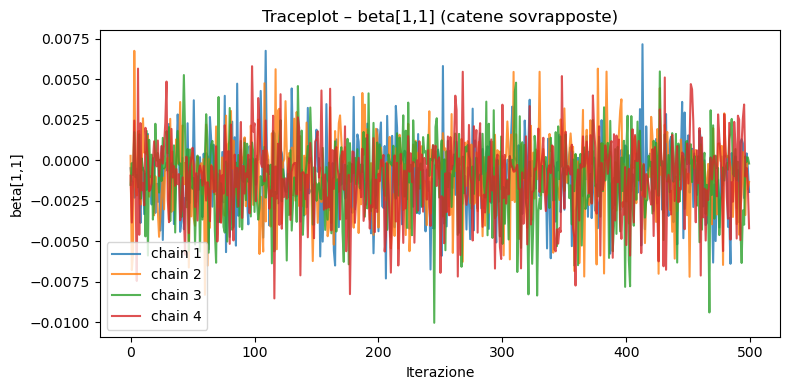

In [15]:
# Interesting plots

beta = fit.stan_variable("beta")
tot_draws, P, K = beta.shape
chains = fit.chains # number of chains
iters = tot_draws // chains # number of draws per chain

beta_chains = beta.reshape(chains, iters, P, K)

fig, ax = plt.subplots(figsize=(8, 4))

for c in range(chains):
    ax.plot(beta_chains[c, :, 0, 0], label=f"chain {c+1}", alpha=0.8)

ax.set_xlabel("Iterazione")
ax.set_ylabel(f"beta[{0+1},{0+1}]")
ax.set_title(f"Traceplot – beta[{0+1},{0+1}] (catene sovrapposte)")
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
with open("Model_1.pkl", "wb") as f:
    pickle.dump(fit, f)